ALL_DATA shape: (3750, 63601)
Epoch 1/10
69/69 - 74s - loss: 3.3806 - accuracy: 0.6138 - val_loss: 0.7511 - val_accuracy: 0.0000e+00 - 74s/epoch - 1s/step
Epoch 2/10
69/69 - 68s - loss: 0.6225 - accuracy: 0.6386 - val_loss: 0.7082 - val_accuracy: 0.6654 - 68s/epoch - 982ms/step
Epoch 3/10
69/69 - 68s - loss: 0.6003 - accuracy: 0.6839 - val_loss: 0.6990 - val_accuracy: 0.6544 - 68s/epoch - 981ms/step
Epoch 4/10
69/69 - 68s - loss: 0.5767 - accuracy: 0.7160 - val_loss: 0.5636 - val_accuracy: 0.7754 - 68s/epoch - 981ms/step
Epoch 5/10
69/69 - 67s - loss: 0.5386 - accuracy: 0.7424 - val_loss: 0.6323 - val_accuracy: 0.6499 - 67s/epoch - 971ms/step
Epoch 6/10
69/69 - 68s - loss: 0.5146 - accuracy: 0.7614 - val_loss: 0.5340 - val_accuracy: 0.7296 - 68s/epoch - 981ms/step
Epoch 7/10
69/69 - 69s - loss: 0.4616 - accuracy: 0.7884 - val_loss: 0.3699 - val_accuracy: 0.8561 - 69s/epoch - 999ms/step
Epoch 8/10
69/69 - 70s - loss: 0.4151 - accuracy: 0.8162 - val_loss: 0.2907 - val_accuracy: 0.8955 - 

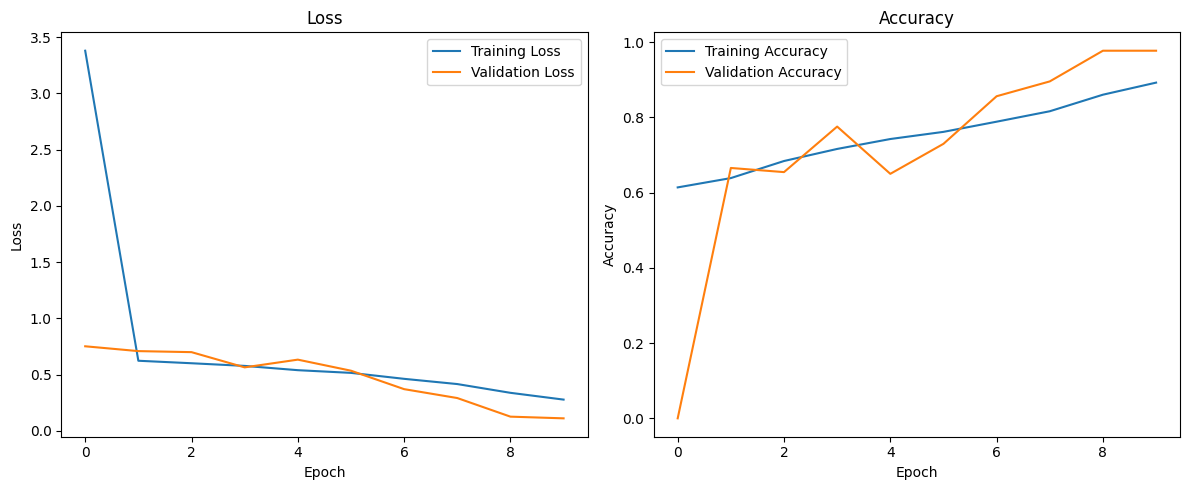

Test Accuracy: 0.8080
24/24 [==============================] - 1s 50ms/step
Test Precision: 0.1415
Test Recall: 0.2206
Test F1 Score: 0.1724


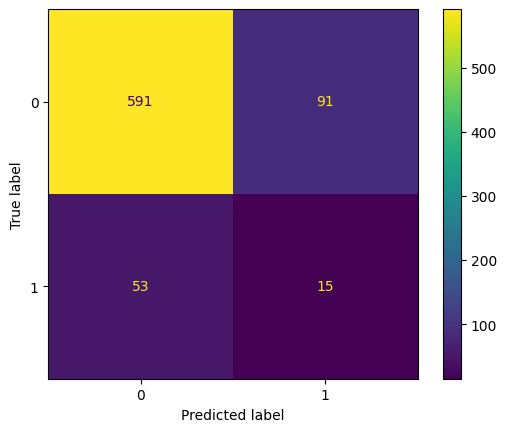

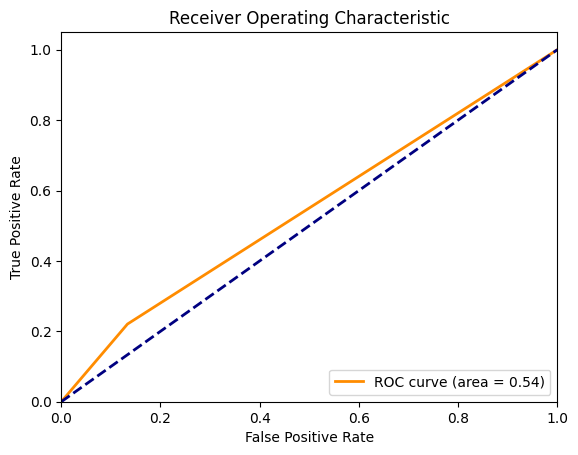

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data Imports and Preprocess
dir_list = os.listdir(NPY_FILEPATH)
npy_arrays = [np.load(os.path.join(NPY_FILEPATH, each)) for each in dir_list]
alls = np.concatenate(npy_arrays, axis=1)
alls_df = pd.DataFrame(alls)
labels_sorted = pd.read_csv(LABELS_SORTED_DF)
labels_sorted.drop(columns=['ecg_id'], inplace=True)
labels_sorted.set_index('Unnamed: 0', inplace=True)


ALL_DATA = pd.concat([alls_df, labels_sorted], axis=1)

#print(f"ALL_DATA shape: {ALL_DATA.shape}")

# Separate features and labels
X = ALL_DATA.iloc[:, :-1].values  # Features
y = ALL_DATA.iloc[:, -1].values   # Labels

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Optional: Data Augmentation
def augment_data(X):
    noise = np.random.normal(0, 0.1, X.shape)
    return X + noise

X_train_augmented = augment_data(X_train_scaled)

# Optional: Class Balancing
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Reshaping
X_train = X_train_resampled[:, :63600].reshape(-1, 5300, 12)
X_test = X_test_scaled[:, :63600].reshape(-1, 5300, 12)
y_train = y_train_resampled.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Model Definition
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', input_shape=(5300, 12)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compiling model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model Training
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping]
)

# Plots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model Eval
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

# Predictions
y_pred = model.predict(X_test).round()

# Moore  matrices
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')

# Confusion Matr.
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Saving the model
model.save('ecg_cnn_model2s.h5')
